# Рекуррентные нейронные сети для прогнозирования временных рядов

В этом ноутбуке мы будем прогнозировать среднее число пассажиров на рейсах некоторой авиакомпании по месяцам, конечно, при помощи рекуррентной неройнной сети!

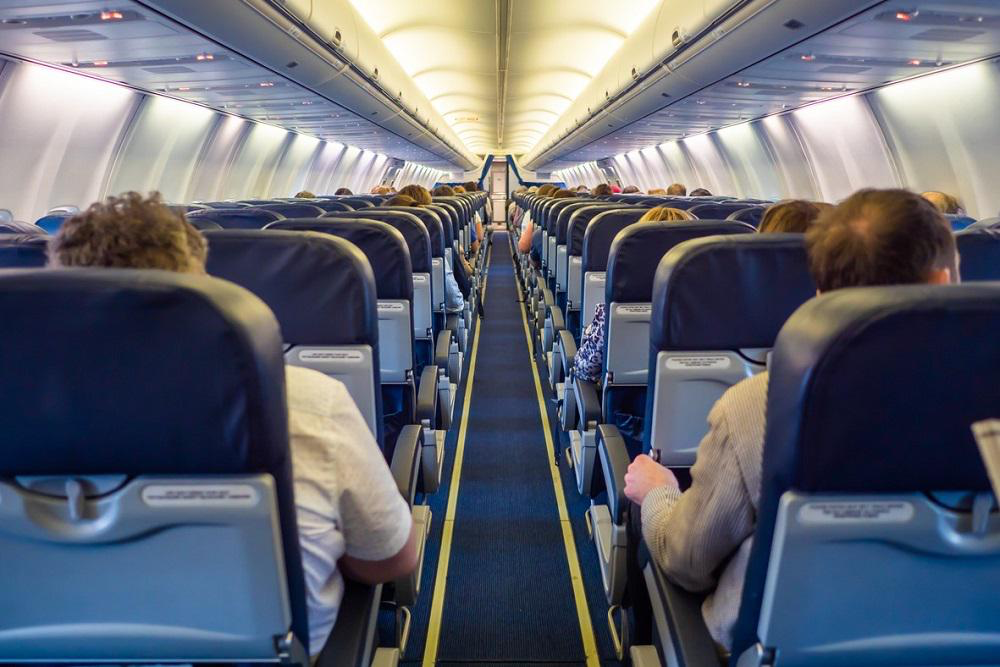

Загрузим данные и посмотрим на них.

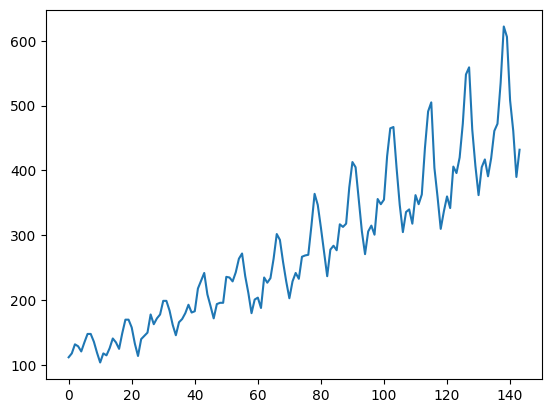

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/rnn_bootcamp/main/airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

Разобъем данные на тренировочную и тестовую части: в задаче прогнозирования временных рядов тест идет строго после трейна

In [2]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

Наша задача - делать прогноз на следующий месяц, то есть на один момент времени вперед. В качестве признаков будем использовать значения ряда за несколько предыдущих месяцев (их число - гиперпараметр, `lookback`).
То есть признаки - это значения ряда $[t-lookback, t]$, а целевая переменная - значение ряда в момент $t+1$.

Нам будет удобнее, чтобы тензор с признаками и тензор целевой переменной были одинаковых размеров, поэтому таргет у нас будет значениями ряда $[t-lookback+1, t+1]$. Все значения, кроме последнего, мы знаем (но они будут полезны при обучении), а уже после обучения нам нужно будет извлечь только последнюю ($t+1$-ю) координату прогноза.

In [3]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

Первый эксперимент - в качестве признаков использовать только одно предыдущее значение ряда ($lookback = 1$).

In [4]:
lookback = 3

X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([93, 3, 1]) torch.Size([93, 3, 1])
torch.Size([45, 3, 1]) torch.Size([45, 3, 1])


<ipython-input-3-7cf0772f622e>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


Создадим класс нашей модели - это простейшая однослойная LSTM, прогноз которой проходит через полносвязный слой.

In [5]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
#        self.bn = nn.BatchNorm1d(num_features=1)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
#        x = self.bn(x)
        x = self.linear(x)
        return x

Далее опишем цикл обучения модели.

In [6]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [8]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 226.0047, test RMSE 424.5007
Epoch 100: train RMSE 177.7620, test RMSE 373.8658
Epoch 200: train RMSE 140.6081, test RMSE 333.1329
Epoch 300: train RMSE 109.6471, test RMSE 296.0115
Epoch 400: train RMSE 86.2518, test RMSE 263.6522
Epoch 500: train RMSE 66.4789, test RMSE 232.0064
Epoch 600: train RMSE 51.8006, test RMSE 203.9061
Epoch 700: train RMSE 41.6781, test RMSE 179.9532
Epoch 800: train RMSE 35.2120, test RMSE 159.6599
Epoch 900: train RMSE 30.2846, test RMSE 142.1326
Epoch 1000: train RMSE 27.1156, test RMSE 127.5867
Epoch 1100: train RMSE 24.8434, test RMSE 115.7133
Epoch 1200: train RMSE 23.4216, test RMSE 106.3136
Epoch 1300: train RMSE 22.5781, test RMSE 99.7803
Epoch 1400: train RMSE 22.0720, test RMSE 93.8991
Epoch 1500: train RMSE 22.5026, test RMSE 90.3006
Epoch 1600: train RMSE 21.5263, test RMSE 88.0059
Epoch 1700: train RMSE 20.7507, test RMSE 85.5823
Epoch 1800: train RMSE 20.5385, test RMSE 83.2377
Epoch 1900: train RMSE 20.3551, test RMSE 82.

Наконец, посмотрим, как работает обученная модель на тестовых данных.

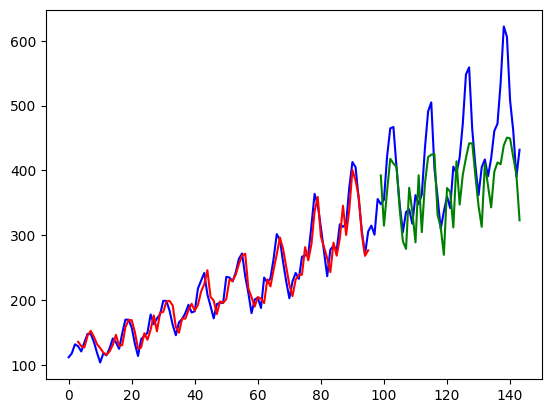

In [9]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

## Эксперименты

1) Задайте `lookback = 3`. Повысилось ли качество прогноза визуально (качество оценивайте по прогнозу на тестовых данных)?

2) Вдобавок к предыдущему изменению добавьте больше эпох (3000). Позволило ли это изменение еще повысить качество модели?

3) А теперь при сохранении предыдущих изменений добавьте еще один слой в LSTM. А это изменение визуально еще улучшило качество?

4) Вернитесь к исходным гиперпараметрам и числу эпох, но добавьте BatchNorm после LSTM-слоя. Как это повлияло на метрики обучения на тесте по сравнению с архитектурой по умолчанию?

5) Используйте любые приемы для улучшения обучения. Какого качества удалось добиться?

In [ ]:
# Ваши эксперименты здесь